# Test Spot2vector on the MOSTA data

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

## Import data

In [2]:
data_name = 'E9.5_E1S1.MOSTA'

In [3]:
n_clusters = 12

In [4]:
adatast = sc.read_h5ad('./data/MOSTA/preprocess_' +  data_name + '.h5ad')

In [5]:
adatast

AnnData object with n_obs × n_vars = 5913 × 8000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 2310011J03Rik', 'Regulon - 5730507C01Rik', 'Regulon - Alx1', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Ar', 'Regulon - Arid3a', 'Regulon - Arid3c', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Ascl1', 'Regulon - Atf1', 'Regulon - Atf4', 'Regulon - Atf5', 'Regulon - Atf6', 'Regulon - Atf7', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barx1', 'Regulon - Batf', 'Regulon - Bcl11a', 'Regulon - Bcl3', 'Regulon - Bcl6', 'Regulon - Bcl6b', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe23', 'Regulon - Bhlhe41', 'Regulon - Bmyc', 'Regulon - Boll', 'Regulon - Bptf', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Bsx', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpa', 'Regulon - Cebpz', 'Regulon - Chd1', 'Regulon - Clock', 'Reg

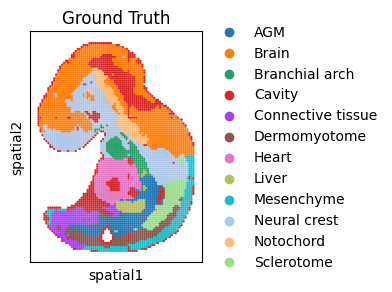

In [6]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adatast, img_key="hires", 
              color="domain_annotation", 
              title="Ground Truth", spot_size=1.2)

In [7]:
sc.pp.pca(adatast, n_comps=10)

## Run Spot2Vector

In [8]:
import Spot2Vector

Spot2Vector.Build_Graph(adatast, radius_cutoff=1.1, cutoff_type='radius', graph_type='spatial')
Spot2Vector.Build_Graph(adatast, neighbors_cutoff=4, cutoff_type='neighbors', graph_type='expression')

The spatial KNN grpah contains 5913 nodes and 23166.0 edges.(except self-loop)
Average degree of spatial graph: 3.92.
The expression KNN grpah contains 5913 nodes and 23652.0 edges.(except self-loop)
Average degree of expression graph: 4.00.


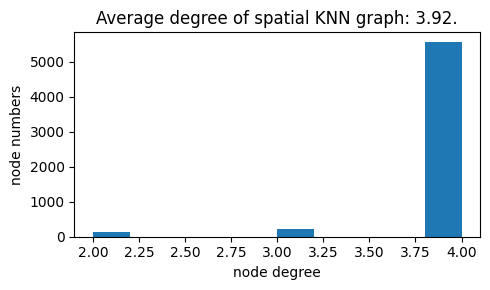

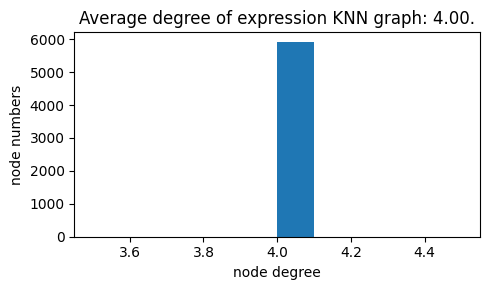

In [9]:
Spot2Vector.Graph_Stat_Plot(adatast)

In [10]:
device = 'cuda:1'
Spot2Vector.Fit(adatast, verbose=False, seed=3, device=device, max_epochs_st=1500)

Training: 100%|██████████| 1500/1500 [12:56<00:00,  1.93epoch/s, epoch=1499, loss=0.548, lr=0.0001]


<Axes: xlabel='epoch', ylabel='loss_total'>

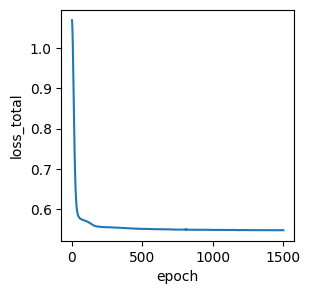

In [11]:
sns.lineplot(adatast.uns['training_history_df_st'], x = 'epoch', y='loss_total')

## Clustering

In [12]:
clust_method = 'mclust'

In [13]:
Spot2Vector.Clustering(adatast, obsm_data='exp_embeddings', method = clust_method, n_cluster=n_clusters, verbose=False)
Spot2Vector.Clustering(adatast, obsm_data='spa_embeddings', method = clust_method, n_cluster=n_clusters, verbose=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


In [14]:
# lamda = 1 for expression, lamda = 0 for spatial
Spot2Vector.Infer(adatast, lamda=0.9, device=device)

In [15]:
Spot2Vector.Clustering(adatast, obsm_data='embeddings', method = clust_method, n_cluster=n_clusters, verbose=False)

fitting ...
  |======================================================================| 100%


In [16]:
Spot2Vector.Clustering_Metrics(adatast, f'embeddings_{clust_method}')

ARI of embeddings_mclust is: 0.4681971477097498
NMI of embeddings_mclust is: 0.604716790183793


## Visualization

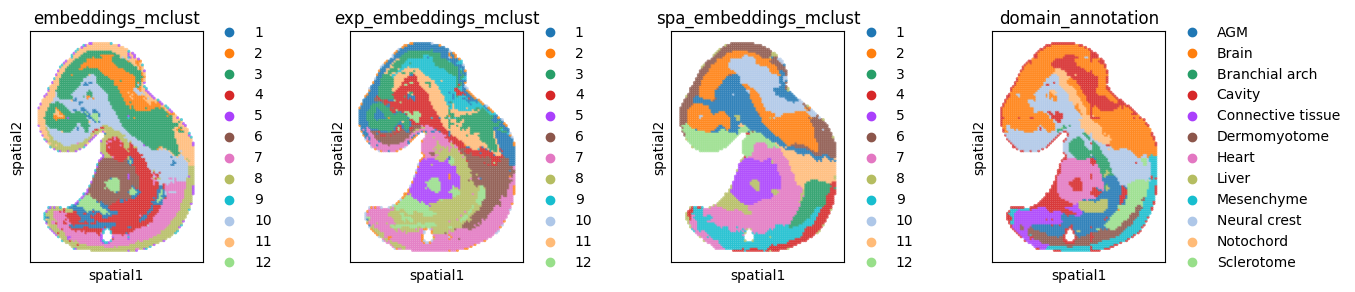

In [17]:
sc.pl.spatial(adatast,
              color=[f"embeddings_{clust_method}",
                     f"exp_embeddings_{clust_method}", 
                     f"spa_embeddings_{clust_method}", 
                     "domain_annotation"], 
              title=[f"embeddings_{clust_method}",
                     f"exp_embeddings_{clust_method}", 
                     f"spa_embeddings_{clust_method}", 
                     "domain_annotation"], 
              size=1.3, 
              alpha=0.7,
              spot_size=1.2)

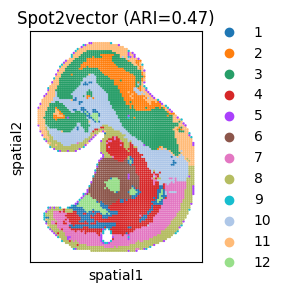

In [18]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adatast, color=f"embeddings_{clust_method}", 
              title='Spot2vector (ARI=' + str(np.round(adatast.uns['embeddings_mclust_ARI'], 2)) + ')', 
              spot_size=1.2,
              save=data_name + '_Spot2vector.svg')